# data processing

In [2]:
import numpy as np
import pandas as pd
import os
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

def remove_pos_bias(pos, direct, d=146):
    """
    remove position bias in pair file
    """
    shift = np.zeros(len(pos))
    shift[np.argwhere(direct=='-')] -= d
    shift[np.argwhere(direct=='+')] += d
    return pos + shift

pair_file = 'data/example.paired' # sampled from wtc11 micro-C data
output_path = 'data'
target_chrom = 'chr21'

df = pd.read_csv(
    pair_file, header=None, sep='\t', comment='#')
df = df[(df.iloc[:,1]==target_chrom) & (df.iloc[:,3]==target_chrom)] # contact within the same chromosome
df = df[abs(df.iloc[:,4] - df.iloc[:,2])>=100]
all_pos = np.array(df.iloc[:, [2, 4]]).flatten()
all_direct = np.array(df.iloc[:, [5, 6]].astype('str')).flatten()
all_direct2 = all_direct[::2]+all_direct[1::2]
d = df.iloc[:, 4] - df.iloc[:, 2]

all_pos_unbiased = remove_pos_bias(all_pos, all_direct, 70)

starts = all_pos_unbiased-80
ends = all_pos_unbiased+80
df = pd.DataFrame(
    {'chr': target_chrom.replace('chr', ''), 'starts': starts.astype(int), 'ends': ends.astype(int)})
df = df[np.logical_and(df.starts>0, df.ends>0)]

df.to_csv(os.path.join(output_path, 'reads.bed'), header=None, index=None, sep='\t')
np.save(os.path.join(output_path, 'all_pos_unbiased'), all_pos_unbiased)


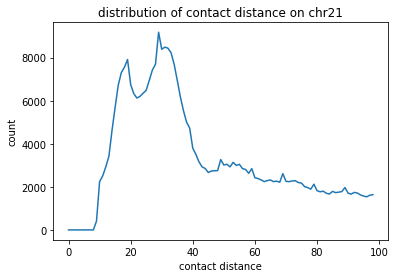

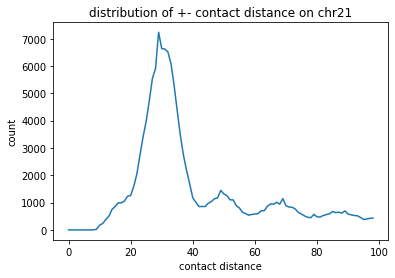

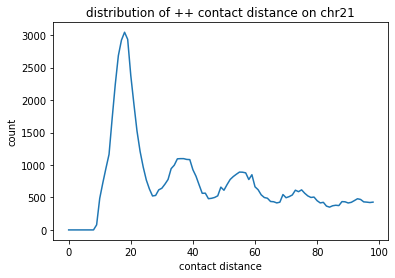

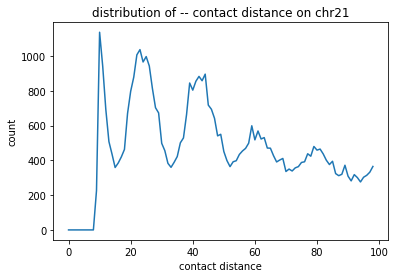

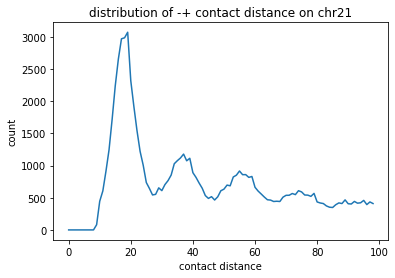

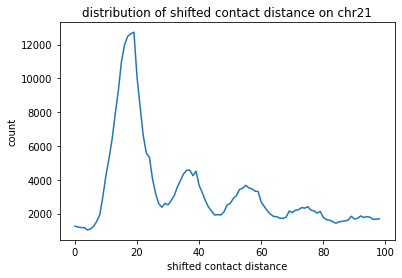

In [3]:
# visualize distances between nucleosomes

s0, _ = np.histogram(d, np.linspace(0, 1000, 100))
s1, _ = np.histogram(d[all_direct2 == '+-'], np.linspace(0, 1000, 100))
s2, _ = np.histogram(d[all_direct2 == '++'], np.linspace(0, 1000, 100))
s3, _ = np.histogram(d[all_direct2 == '-+'], np.linspace(0, 1000, 100))
s4, _ = np.histogram(d[all_direct2 == '--'], np.linspace(0, 1000, 100))
plt.plot(s0)
plt.title(f'distribution of contact distance on {target_chrom}')
plt.xlabel('contact distance')
plt.ylabel('count')
plt.show()
plt.plot(s1)
plt.title(f'distribution of +- contact distance on {target_chrom}')
plt.xlabel('contact distance')
plt.ylabel('count')
plt.show()
plt.plot(s2)
plt.title(f'distribution of ++ contact distance on {target_chrom}')
plt.xlabel('contact distance')
plt.ylabel('count')
plt.show()
plt.plot(s3)
plt.title(f'distribution of -- contact distance on {target_chrom}')
plt.xlabel('contact distance')
plt.ylabel('count')
plt.show()
plt.plot(s4)
plt.title(f'distribution of -+ contact distance on {target_chrom}')
plt.xlabel('contact distance')
plt.ylabel('count')
plt.show()

s5, _ = np.histogram(abs(all_pos_unbiased[::2] - all_pos_unbiased[1::2]), np.linspace(0, 1000, 100))
plt.plot(s5)
# plt.ylim(0, 1e4)
plt.title(f'distribution of shifted contact distance on {target_chrom}')
plt.xlabel('shifted contact distance')
plt.ylabel('count')
plt.show()

In [7]:
!bedtools getfasta -fi /nfs/turbo/umms-drjieliu/usr/hyhao/nucleomap_organized/NucleoMap/data/reference_genome/hg38_chr21.fa -bed data/reads.bed > data/nuc_sequence.fa

# generate PWM (Optional)

In [8]:
def count_freq(f):
    freq = []
    for l in f:
        if l.startswith('>'):
            continue
        else:
            freq.append([l.strip()[i:i+2] for i in range(0, len(l.strip()), 2)])
    freq = np.array(freq)
    freq2 = np.where((freq=='AT')|(freq=='TA')|(freq=='AA')|(freq=='TT'), 1, 0)
#     freq2 = np.where((freq=='AA')|(freq=='GA')|(freq=='AG')|(freq=='GG'), 1, 0)
    return freq2.sum(0)/freq2.shape[0]

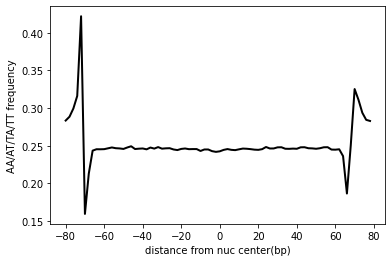

In [9]:
f = open('data/nuc_sequence.fa')

freqs = count_freq(f)
plt.plot(np.arange(-int(len(freqs)), int(len(freqs)), 2), freqs, color='black', linewidth=2, ls='-')
plt.ylabel('AA/AT/TA/TT frequency')
plt.xlabel('distance from nuc center(bp)')
plt.show()

pfm = np.vstack([freqs, (1-freqs)/3])
pwm = np.log2(pfm*4)
np.save('data/nuc_pwm', pwm)

# call nucleosomes

In [ ]:
from utils import dpmeans, encode_seq, fasta_iter

path = 'data'
read_centers = 'data/all_pos_unbiased.npy'
pwm = 'data/nuc_pwm.npy'
# pwm = None
seqfile = 'data/reference_genome/hg38_chr21.fa'
lbd = 10

all_pos_unbiased = np.load(read_centers)
if pwm:
    pwm = np.load(pwm)
    seq_file = seqfile
part_pos = all_pos_unbiased

bin_len = 1000
bins = np.arange(min(part_pos), max(part_pos)+bin_len, bin_len)
min_ends = 10
assignment = np.digitize(part_pos, bins=bins)-1
contact_assignment = (np.digitize(all_pos_unbiased, bins=bins)-1).reshape([-1,2])
c = all_pos_unbiased.reshape([-1,2])
n_peaks = 0
w = 1000000 # cl element penalty
w2 = 10 #seq coef
peaks = []
pi = np.zeros(len(part_pos))
lbd = int(lbd)
if pwm is not None:
    fiter = fasta_iter(seq_file)

    for ff in fiter:
        header, seq = ff
        e = encode_seq(seq)
        e2 = encode_seq(seq[1:])
        scores = np.correlate(e, pwm[0], 'same') + np.correlate(1-e, pwm[1], 'same')
        scores2 = np.correlate(e2, pwm[0], 'same') + np.correlate(1-e2, pwm[1], 'same')
        scores = np.vstack([scores, np.r_[scores2, 0]]).T.flatten()
        scores = w2*(scores-scores.mean())/np.std(scores)
else:
    scores = 0

for i in range(len(bins)-1):
    bin_start = bins[i]
    if (i+1)%100 == 0:
        print(f'iteration: {i}, n_peaks: {n_peaks}, len(peaks): {len(np.concatenate(peaks))}, len(pi): {max(pi)+1}')
    idx = assignment==i
    ends = part_pos[idx]

    idx2 = (contact_assignment==i).all(1)
    cl_idx = c[idx2]
    cl_pair = []
    # search idx
    k = 0
    if cl_idx.shape[0]>0:
        for j in range(len(ends)-1):
            if (ends[j:j+2] == cl_idx[k]).all():
                cl_pair.append([j,j+1])
                k+=1
            if k==cl_idx.shape[0]:
                break

    if len(ends) > min_ends:
        cl_graph = {}
        for i in range(len(ends)):
            cl_graph[i] = set()
        for i in cl_pair:
            cl_graph[i[0]] = set([i[1],])
            cl_graph[i[1]] = set([i[0],])
        
        labels, mus = dpmeans(ends.reshape([-1,1]), w=w, cl_graph=cl_graph, Lambda=lbd, scores=scores).fit(ends.reshape([-1,1]))
    elif len(ends) == 0:
        continue
    else:
        mus = ends.mean()
        labels = np.zeros(ends.shape)

    k = len(mus.flatten())
    peaks.append(mus.flatten())
    pi[idx] = labels+n_peaks
    n_peaks += k

nuc = np.sort(np.concatenate(peaks).astype(int))
assignment = np.digitize(all_pos_unbiased, (nuc[:-1] + nuc[1:])/2).reshape([-1,2])

np.save(os.path.join(path, f'read_assignment'), assignment.flatten())
np.save(os.path.join(path, f'called_nucs'), nuc)

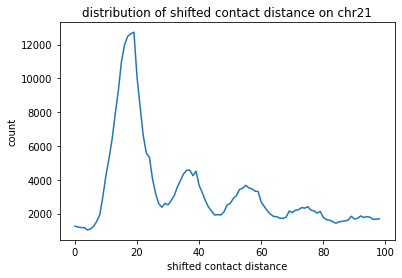

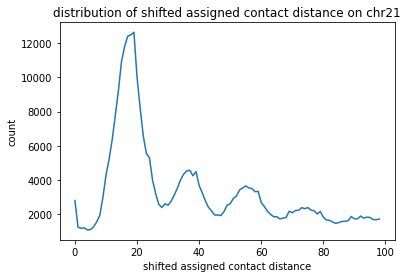

In [109]:
# visualize original read density and reconstructed read density using the called nucleosomes
s5, _ = np.histogram(abs(all_pos_unbiased[::2] - all_pos_unbiased[1::2]), np.linspace(0, 1000, 100))
plt.plot(s5)
plt.title(f'distribution of shifted contact distance on {target_chrom}')
plt.xlabel('shifted contact distance')
plt.ylabel('count')
plt.show()

s5, _ = np.histogram(abs(nuc[assignment][:,1] - nuc[assignment][:,0]), np.linspace(0, 1000, 100))
plt.plot(s5)
plt.title(f'distribution of shifted assigned contact distance on {target_chrom}')
plt.xlabel('shifted assigned contact distance')
plt.ylabel('count')
plt.show()